# Simulating IT Cortex Face Responsivity Through Deep Learning Models

### Imports and Labelling the Dataset

In [1]:
import kagglehub
import os
import math

import torch
import numpy as np
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import GaussianBlur

import matplotlib.pyplot as plt
import torch
from PIL import Image
import random

import warnings
warnings.filterwarnings("ignore")

# Set a seed
random.seed(552)

# Download path
PATH = kagglehub.dataset_download("sagarkarar/nonface-and-face-dataset")

# Transform images
IMG_SIZE = 60

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # grayscale
    transforms.ToTensor(),  # make tensor
    transforms.Resize((IMG_SIZE, IMG_SIZE)), # make all images the same size
    # transforms.Normalize(mean=[0.5], std=[0.5])  # normalize
])

dataset = datasets.ImageFolder(PATH, transform=transform)

for i in range(len(dataset)):
    file_path, label = dataset.samples[i]
    file_name = file_path.split('/')[-1]

    # Assign binary label based on file name
    new_label = 1 if 'Human' in file_name else 0

    # Update the tuple in-place
    dataset.samples[i] = (file_path, new_label)

### Sample from the Dataset

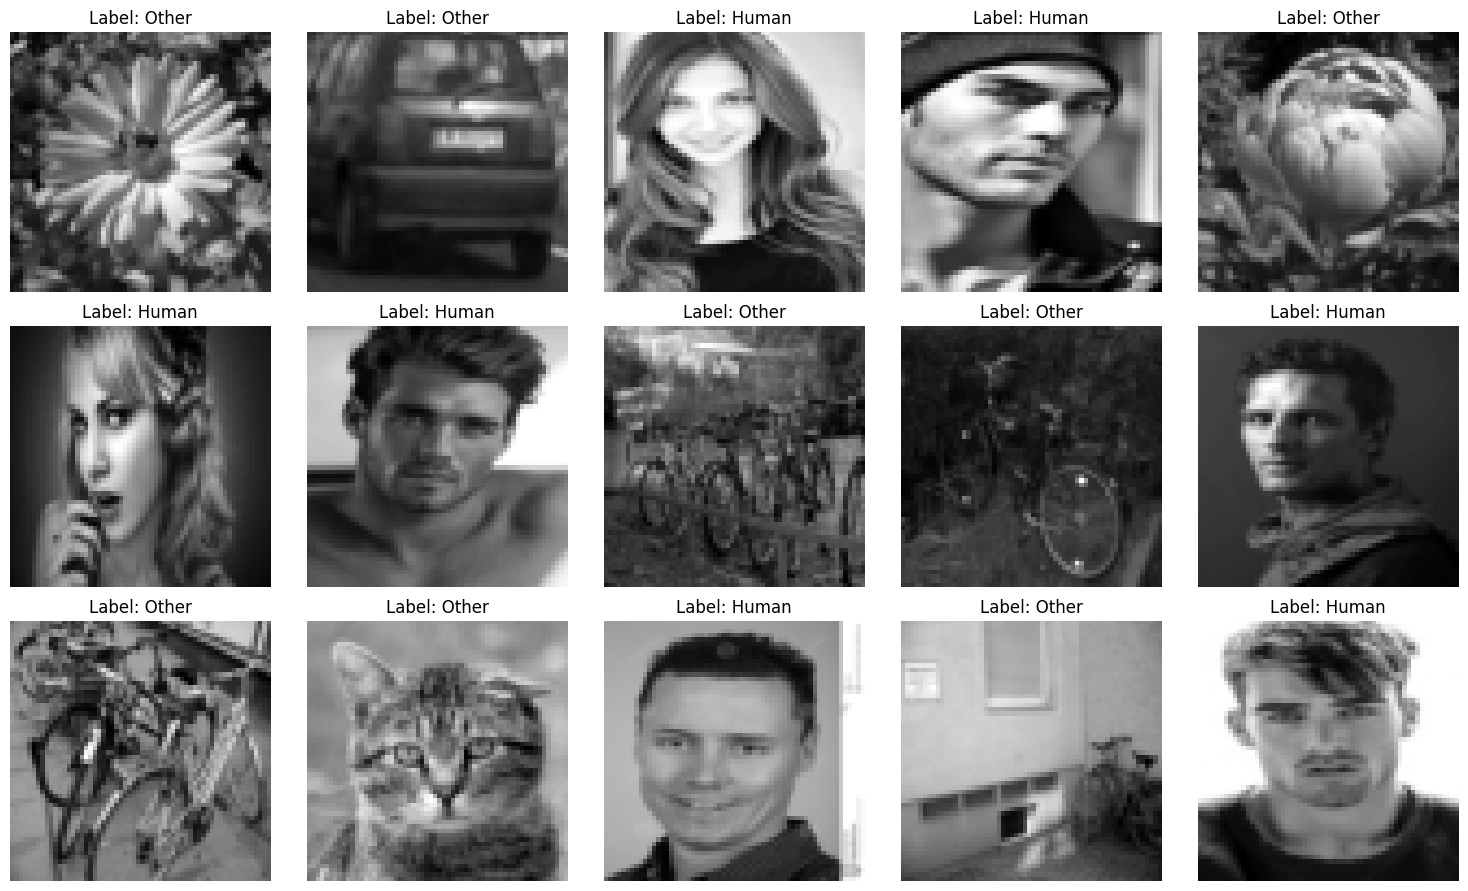

In [2]:
def plot_images(dataset, num_images=10, inds=None):
  ''' Generates a plot of images randomly selected from the dataset, unless indices of images to plot are provided.

  Inputs: - dataset
          - num_images: number of images to plot
          - inds: indices of images to plot, if None, random images will be selected
  Output: - list of indices of images selected
  '''
  images_per_row = 5
  rows = (num_images + images_per_row - 1) // images_per_row
  fig, axes = plt.subplots(rows, images_per_row, figsize=(images_per_row * 3, rows * 3))
  axes = axes.flatten()

  ind_out = []
  rng = num_images if inds is None else len(inds)
  for i in range(rng):
      if not inds:
        j = random.randint(0, len(dataset) - 1)
      ind_out.append(j)
      image, label = dataset[j]
      image = image.numpy().transpose(1, 2, 0)

      axes[i].imshow(image, cmap='gray')
      axes[i].set_title(f"Label: {'Human' if label else 'Other'}")
      axes[i].axis('off')

  # Hide any remaining empty subplots
  for i in range(num_images, len(axes)):
      axes[i].axis('off')

  plt.tight_layout()
  plt.show()

  return ind_out

# plot 15 random images
ind_out = plot_images(dataset, num_images=15)

### Creating Balanced Test and Train Datasets

In [3]:
PERCENT_TOTAL = 0.5 # use only 25% of the full dataset
PERCENT_TRAIN = 0.8   # 80% train, 20% test
def prepare_train_and_test(dataset, percent_total, percent_train, test_fifth=None):
  ''' Prepare train and test subsets, as well as data loaders.
  There will be an equal amount of labels of each class in both the training and testing sets.

  Inputs: - dataset
          - percent_total: percentage for the subset of the total dataset
          - percent_train: percentage for the training set from the subset
          - test_fifth: 0 through 4 indicating which fifth to use as the test set if percent
                        train is set to 0.8
                        -> If percent_train ≠ 0.8, then test_fifth = None
  Output: - X_train, X_test, train_loader, test_loader
  '''
  # Separate indices by label
  human_indices = [i for i, (path, label) in enumerate(dataset.samples) if label == 1]
  other_indices = [i for i, (path, label) in enumerate(dataset.samples) if label == 0]

  # Equal amount of each class
  N = int(len(dataset) * percent_total)
  half_N = N // 2

  # Shuffle and select half_N of each class
  # np.random.shuffle(human_indices)
  # np.random.shuffle(other_indices)
  selected_humans = human_indices[:half_N]
  selected_others = other_indices[:half_N]

  # Combine and shuffle together
  selected_indices = selected_humans + selected_others
  np.random.seed(42)  # or any integer seed you like
  np.random.shuffle(selected_indices)
  # np.random.shuffle(selected_indices)

  # Split into train and test
  if test_fifth:
    fifth_size = N // 5
    start = test_fifth * fifth_size
    end = (test_fifth + 1) * fifth_size if test_fifth < 4 else N  # make sure to include all in the last case

    test_indices = selected_indices[start:end]
    train_indices = selected_indices[:start] + selected_indices[end:]
    print(test_indices)
  else:
    num_train = int(percent_train * N)
    train_indices = selected_indices[:num_train]
    test_indices = selected_indices[num_train:]

  # Create subsets
  X_train = torch.utils.data.Subset(dataset, train_indices)
  X_test = torch.utils.data.Subset(dataset, test_indices)

  train_loader = torch.utils.data.DataLoader(X_train, batch_size=100, shuffle=True)
  test_loader = torch.utils.data.DataLoader(X_test, batch_size=100, shuffle=True)

  return X_train, X_test, train_loader, test_loader

X_train, X_test, train_loader, test_loader = prepare_train_and_test(dataset, PERCENT_TOTAL, PERCENT_TRAIN, 1)

[1177, 920, 52, 1372, 959, 1124, 890, 252, 75, 949, 353, 472, 1272, 760, 897, 1115, 1182, 185, 1117, 1127, 1159, 322, 1039, 1132, 885, 1056, 1264, 327, 1376, 219, 908, 46, 1155, 486, 646, 131, 1240, 183, 291, 176, 846, 311, 1059, 540, 60, 906, 657, 408, 1277, 6, 1229, 334, 1333, 1244, 1104, 1081, 1058, 627, 1235, 435, 335, 511, 456, 342, 928, 1037, 614, 439, 1044, 1102, 144, 1092, 1214, 278, 838, 539, 1165, 239, 83, 164, 636, 155, 1040, 1035, 161, 592, 1179, 1016, 1077, 1098, 243, 809, 1329, 588, 145, 193, 351, 1185, 1083, 654, 1243, 1317, 507, 1188, 206, 90, 136, 1256, 1078, 1212, 1068, 602, 833, 879, 92, 1247, 921, 1322, 1010, 162, 1411, 429, 14, 1082, 1105, 888, 1131, 1042, 416, 1208, 891, 346, 1365, 1285, 889, 498, 364, 974, 121, 1024, 1073, 566, 1075, 1323, 141, 345, 1276, 567, 31, 1170, 102, 149, 257, 1217, 1352, 598, 1328, 331, 1341, 587, 1071, 1211, 110, 8, 544, 255, 789, 780, 992, 49, 268, 886, 1060, 443, 1308, 184, 508, 652, 548, 753, 861, 244, 480, 488, 341, 1374, 246, 1126,

In [4]:
def count_labels_binary(subset, prepare_train_and_test=True):
  '''Returns the number of human labels and the number of other labels in a subset.
  Is able to process a dataset that was prepared using the prepare_train_and_test() function, or an untransformed dataset.

  Inputs: - subset
          - prepare_train_and_test: set to False if the subset is not transformed; is not an output of prepare_train_and_test()
  Output: - num_human, num_other
  '''
  labels = [subset.dataset.samples[i][1] for i in subset.indices] if prepare_train_and_test else [label for _, label in subset.samples]
  num_human = sum(1 for label in labels if label == 1)
  num_other = sum(1 for label in labels if label == 0)
  return num_human, num_other

# Get counts
num_human_train, num_other_train = count_labels_binary(X_train)
num_human_test, num_other_test = count_labels_binary(X_test)

print(f"Train: Human: {num_human_train}, Other: {num_other_train}")
print(f"Test: Human: {num_human_test}, Other: {num_other_test}")

Train: Human: 524, Other: 536
Test: Human: 138, Other: 126


### CNNs Definitions (basic, intermediate, and advanced)

In [5]:
class Net1(nn.Module):
  ''' Basic CNN containing:
  - 2 convolutional layers
  - 2 max pooling layers (after each conv layer)
  - 2 fully connected layers
  - ReLU activations after every conv and the first linear layer
  - Log-Softmax at the end for outputting class probabilities
  '''
  def __init__(self):
      super(Net1, self).__init__()
      self.conv1 = nn.Conv2d(1, 12, kernel_size=9, padding=4)
      self.conv2 = nn.Conv2d(12, 20, kernel_size=9, padding=4)
      self.pool = nn.MaxPool2d(2, 2)  # Max pooling with stride 2 to downsample
      self.fc1 = nn.Linear(20 * 15 * 15, 50)  # Adjusted based on expected output size
      self.fc2 = nn.Linear(50, 2)

  def forward(self, x):
      x = F.relu(F.max_pool2d(self.conv1(x), 2))  # Conv + ReLU + Pooling
      x = F.relu(F.max_pool2d(self.conv2(x), 2))  # Conv + ReLU + Pooling
      x = x.view(x.size(0), -1)
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      return F.log_softmax(x, dim=1)  # Log-softmax for binary classification

network1 = Net1()

In [6]:
class Net2(nn.Module):
    ''' Intermediate CNN with:
    - 3 convolutional layers - additional layer to learn deeper features like eyes and nose
    - Max pooling after each conv for more stability
    - BatchNorm for stability - to avoid exploding gradients during back prop but only on activations
    - Dropout for regularization to avoid overfitting to data
    - Fully connected layers
    '''
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=9, padding=2)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)

        self.fc1 = nn.Linear(64 * 7 * 7, 100)  # depends on input size, assumes 60x60 input
        self.fc2 = nn.Linear(100, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

network2 = Net2()


In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels,
                          kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)


class Net3(nn.Module):
    ''' Advanced CNN with residual connections:
    - 3 residual blocks
    - 2 fully connected layers
    '''
    def __init__(self):
        super(Net3, self).__init__()
        self.layer1 = ResidualBlock(1, 32, stride=1)
        self.layer2 = ResidualBlock(32, 64, stride=2)
        self.layer3 = ResidualBlock(64, 128, stride=2)

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, 2)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

network3 = Net3()


### Training Function

In [8]:
# Training Function
def continue_training(network, optimizer, data, accuracy_train=[], accuracy_test=[]):
  ''' Continues training the network for 10 iterations, then computes the testing score

  Inputs: - network
          - optimizer: for the network
          - data: tuple containing (train_loader, test_loader)
          - accuracy_train: list of training accuracy values (this can contain prev. training accuracies, list will be appended to)
          - accuracy_test: list of testing accuracy values (this can contain prev. testing accuracies, list will be appended to)
  Output: - accuracy_train, accuracy_test
  '''
  train_loader, test_loader = data
  network.train()      # configure the network for training
  for i in range(10):  # train the network 10 times
      correct = 0
      for data, target in train_loader:       # working in batchs of 1000
          optimizer.zero_grad()               # initialize the learning system
          output = network(data)              # feed in the data
          loss = F.nll_loss(output, target)   # compute how wrong the output is
          loss.backward()                     # change the weights to reduce error
          optimizer.step()                    # update the learning rule

          pred = output.data.max(1, keepdim=True)[1]           # compute which output is largest
          correct += pred.eq(target.data.view_as(pred)).sum()  # compute the number of correct outputs

      score = float(correct/len(train_loader.dataset))
      accuracy_train.append(score)
      print(f'Training accuracy #{len(accuracy_train)}: {score}')

  correct = 0
  network.eval()
  with torch.no_grad():
    for data, target in test_loader:    # go through the test data once (in groups of 1000)
        output = network(data)                               # feed in the data
        pred = output.data.max(1, keepdim=True)[1]           # compute which output is largest
        correct += pred.eq(target.data.view_as(pred)).sum()  # compute the number of correct outputs
  # update the list of testing accuracy values
  score = float(correct/len(test_loader.dataset))
  accuracy_test.append(score)
  print(f'Testing accuracy #{len(accuracy_test)} (after {len(accuracy_train)} training iterations): {score}')

  return accuracy_train, accuracy_test

def train_net(network, data, iterations=1):
  ''' Runnings continue training for a set amount of iterations given a network.

  Inputs: - network
          - data: tuple containing (train_loader, test_loader)]
          - iterations: number of times to run continue_training()
  Output: - accuracy_train, accuracy_test
  '''
  # create the learning rule
  optimizer = torch.optim.SGD(network.parameters(),
                              lr=0.1,   # learning rate
                              momentum=0.5)

  # variables to keep track of the training and testing accuracy
  accuracy_train = []
  accuracy_test = []

  for i in range(iterations):
    accuracy_train, accuracy_test = continue_training(network, optimizer, data, accuracy_train, accuracy_test)

  return accuracy_train, accuracy_test

# Testing Function
def test_net(network, dataloader):
  ''' Computes the testing score on images

  Inputs: - network
          - data: test_loader
  Output: - accuracy_train, accuracy_test
  '''
  network.eval()
  correct = 0
  with torch.no_grad():
      for inputs, targets in dataloader:
          output = network(inputs)
          pred = output.data.max(1, keepdim=True)[1]
          correct += pred.eq(targets.data.view_as(pred)).sum()
  score = float(correct.item()) / len(dataloader.dataset)
  # print(f'Testing accuracy: {score}')
  return score

### Activation Layer Collection + Filter and Activation Layer Plotting Functions

In [9]:
def plot_filters(conv_layers):
  ''' Plots all the filters in each convolution layer, given a list of convolutional layers.

  Inputs: - conv_layers: list of convolutional layers
  Output: - None
  '''
  for conv in conv_layers:
    filters = conv.weight.data.numpy()
    num_filters = filters.shape[0]
    filters_per_row = 5

    # Loop over filters in groups of 5
    for start in range(0, num_filters, filters_per_row):
        end = min(start + filters_per_row, num_filters)
        actual_count = end - start

        fig, axes = plt.subplots(1, filters_per_row, figsize=(15, 3))

        if filters_per_row == 1:
            axes = [axes]

        for i in range(filters_per_row):
            ax = axes[i]
            if i < actual_count:
                ax.imshow(filters[start + i][0], cmap='gray')
                ax.set_title(f"Filter {start + i + 1}")
            else:
                ax.imshow(np.zeros_like(filters[0][0]), cmap='gray')  # Empty filter to pad layout
                ax.set_title("")

            ax.axis('off')

        plt.tight_layout()
        plt.show()


In [10]:
# plot_filters([network1.conv1, network1.conv2])

# plot_filters([network2.conv1, network2.conv2, network2.conv3])

# plot_filters([
#     network3.layer1.conv1,
#     network3.layer1.conv2,
#     network3.layer2.conv1,
#     network3.layer2.conv2,
#     network3.layer3.conv1,
#     network3.layer3.conv2
# ])

In [11]:
class ActivationCollector:
    def __init__(self, layers):
        self.activations = []
        self.handles = []
        self._register_hooks(layers)

    def _hook_fn(self, module, input, output):
        self.activations.append(output)

    def _register_hooks(self, layers):
        # Remove old hooks if any
        self.remove_hooks()
        # Register new hooks
        for layer in layers:
            handle = layer.register_forward_hook(self._hook_fn)
            self.handles.append(handle)

    def remove_hooks(self):
        for h in self.handles:
            h.remove()
        self.handles = []

    def clear_activations(self):
        self.activations.clear()

    def get_activations(self):
        return self.activations

In [12]:
def plot_all_activations(activations, max_filters=20):
  """
  Plots feature maps for a list of activations.

  Inputs: - activations: list of activations
          - titles: optional titles for each layer
          - max_filters: max number of filters to plot per layer
  """
  for idx, activation in enumerate(activations):
      activation = activation[0]  # Take first image in batch
      num_filters = min(activation.shape[0], max_filters)

      # Calculate grid size
      cols = math.ceil(math.sqrt(num_filters))
      rows = math.ceil(num_filters / cols)

      fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
      fig.suptitle(f'Layer {idx+1}', fontsize=16)

      for i in range(rows * cols):
          if rows == 1:
              ax = axes[i % cols]
          elif cols == 1:
              ax = axes[i // cols]
          else:
              ax = axes[i // cols, i % cols]

          if i < num_filters:
              ax.imshow(activation[i].detach().numpy(), cmap='viridis')
          ax.axis('off')

      plt.tight_layout()
      plt.show()

In [13]:
def plot_last_filter_activations(activations, title_in=''):
    '''
    Plots the last filter activation map (normalized) from each activation tensor in the list.

    Inputs: - activations: list of activations
    '''
    num_layers = len(activations)
    fig, axes = plt.subplots(1, num_layers, figsize=(6 * num_layers, 6))
    if num_layers == 1:
        axes = [axes]

    for idx, activation in enumerate(activations):
        last_map = activation[0, -1].detach().numpy()
        normalized_map = (last_map - np.min(last_map)) / (np.max(last_map) - np.min(last_map) + 1e-8)

        axes[idx].imshow(normalized_map, cmap='hot')
        title = f"Last Filter Activation (Layer {idx+1})"
        axes[idx].set_title(title)
        axes[idx].axis('off')
        fig.colorbar(axes[idx].imshow(normalized_map, cmap='hot'), ax=axes[idx])

    if title_in:
        fig.suptitle(title_in, fontsize=16, y=1.02)

    plt.tight_layout()
    plt.show()

### Image Modification Functions

In [14]:
from random import randint

def modify_image(data, modification, size = "small", blur_size = 1):
  ''' Function that modifies an image.

  Inputs: - data: image
          - modification: string that specifies the modification to apply, following modifications are excepted:
                          - vertical_stripe
                          - horizontal_stripe
                          - blur
                          - etc
  Output: - modified image
  '''
  img_modified = data.clone().detach()

  if size == "small":
    start = randint(0, 60 - 5)
    end = randint(start + 5, start + 10)
  elif size == "medium" :
    start = randint(0, 60 - 10)
    end = randint(start + 10, 60)
  else:
    start = randint(0, 60 - 15)
    end = randint(start + 15, 60 + 5)

  if modification == 'horizontal_stripe':
    mask = torch.zeros_like(img_modified)
    mask[0, 0, start:end, :] = 1.0

    img_modified = img_modified * (1 - mask) + mask * 1.0
  elif modification == 'vertical_stripe':
    mask = torch.zeros_like(img_modified)
    mask[0, 0, :, start:end] = 1.0

    img_modified = img_modified * (1 - mask) + mask * 1.0

  elif modification == 'blur':
    # Calculate kernel size based on sigma (blur_size)
    kernel_size = 21

    blur = GaussianBlur(kernel_size=kernel_size, sigma=blur_size)
    img_modified = blur(img_modified[0])
    img_modified = img_modified.unsqueeze(0)

  return img_modified

In [15]:
def generate_shifted_stripes(data, stripe_size=10, step=10, direction='horizontal', size='medium'):
    '''
    Generates multiple images with a shifting stripe, either horizontal or vertical.

    Inputs:
    - data: input image tensor
    - stripe_size: height (for horizontal) or width (for vertical) of the stripe
    - step: number of pixels to move the stripe each iteration
    - direction: 'horizontal' or 'vertical'
    - size: for future extensibility; currently unused

    Output:
    - List of modified images with shifted stripes
    '''
    img_height = data.shape[2]
    img_width = data.shape[3]
    outputs = []

    if direction == 'horizontal':
        for start in range(0, img_height - stripe_size + 1, step):
            end = start + stripe_size
            img_modified = data.clone().detach()
            mask = torch.zeros_like(img_modified)
            mask[0, 0, start:end, :] = 1.0
            img_modified = img_modified * (1 - mask) + mask * 1.0
            outputs.append(img_modified)

    elif direction == 'vertical':
        for start in range(0, img_width - stripe_size + 1, step):
            end = start + stripe_size
            img_modified = data.clone().detach()
            mask = torch.zeros_like(img_modified)
            mask[0, 0, :, start:end] = 1.0
            img_modified = img_modified * (1 - mask) + mask * 1.0
            outputs.append(img_modified)

    else:
        raise ValueError("Direction must be 'horizontal' or 'vertical'.")

    return outputs


In [16]:
# accuracy_train_net1, accuracy_test_net1 = train_net(network1, (train_loader, test_loader), 1)
# accuracy_train_net2, accuracy_test_net2 = train_net(network2, (train_loader, test_loader), 1)
# accuracy_train_net3, accuracy_test_net3 = train_net(network3, (train_loader, test_loader), 1)

### Model Training and Testing on Unmodified Dataset

In [ ]:
PERCENT_TOTAL = 0.5
PERCENT_TRAIN = 0.8
K = 5

network1_all, network2_all, network3_all = [], [], []
total_net1_train, total_net2_train, total_net3_train = [], [], []
total_net1_test, total_net2_test, total_net3_test = [], [], []

for fold in range(K):
    print(f"--- Fold {fold + 1} ---")
    X_train, X_test, train_loader, test_loader = prepare_train_and_test(
        dataset, PERCENT_TOTAL, PERCENT_TRAIN, test_fifth=fold
    )

    # Reinitialize networks for each fold
    net1 = Net1()
    net2 = Net2()
    net3 = Net3()

    # Train each network
    acc_train1, acc_test1 = train_net(net1, (train_loader, test_loader), 1)
    acc_train2, acc_test2 = train_net(net2, (train_loader, test_loader), 1)
    acc_train3, acc_test3 = train_net(net3, (train_loader, test_loader), 1)

    # Store networks
    network1_all.append(net1)
    network2_all.append(net2)
    network3_all.append(net3)

    # Store accuracies
    total_net1_train.append(acc_train1)
    total_net2_train.append(acc_train2)
    total_net3_train.append(acc_train3)

    total_net1_test.append(acc_test1)
    total_net2_test.append(acc_test2)
    total_net3_test.append(acc_test3)


--- Fold 1 ---
Training accuracy #1: 0.5826250910758972
Training accuracy #2: 0.605288028717041
Training accuracy #3: 0.5816808342933655
Training accuracy #4: 0.6685552597045898
Training accuracy #5: 0.5741265416145325
Training accuracy #6: 0.4948064088821411
Training accuracy #7: 0.47780925035476685
Training accuracy #8: 0.46647781133651733
Training accuracy #9: 0.46742209792137146
Training accuracy #10: 0.5051935911178589
Testing accuracy #1 (after 10 training iterations): 0.47924527525901794
Training accuracy #1: 0.6270065903663635
Training accuracy #2: 0.6968838572502136
Training accuracy #3: 0.801699697971344
Training accuracy #4: 0.8555240631103516
Training accuracy #5: 0.8517469167709351
Training accuracy #6: 0.8895184397697449
Training accuracy #7: 0.9216241836547852
Training accuracy #8: 0.9386213421821594
Training accuracy #9: 0.9291784763336182
Training accuracy #10: 0.9612842202186584
Testing accuracy #1 (after 10 training iterations): 0.8075471520423889
Training accuracy #

In [ ]:
# def big_list(accuracy_train_net1):
#   total_list = [
#       [val + 0.01 * i for val in accuracy_train_net1]
#       for i in range(5)
#   ]

#   return total_list

# total_net1_train = big_list(accuracy_train_net1)
# total_net2_train = big_list(accuracy_train_net2)
# total_net3_train = big_list(accuracy_train_net3)

# total_net1_test = [i[0] for i in big_list(accuracy_test_net1)]
# total_net2_test = [i[0] for i in big_list(accuracy_test_net2)]
# total_net3_test = [i[0] for i in big_list(accuracy_test_net3)]

### Testing and Training Results on Unmodified Dataset

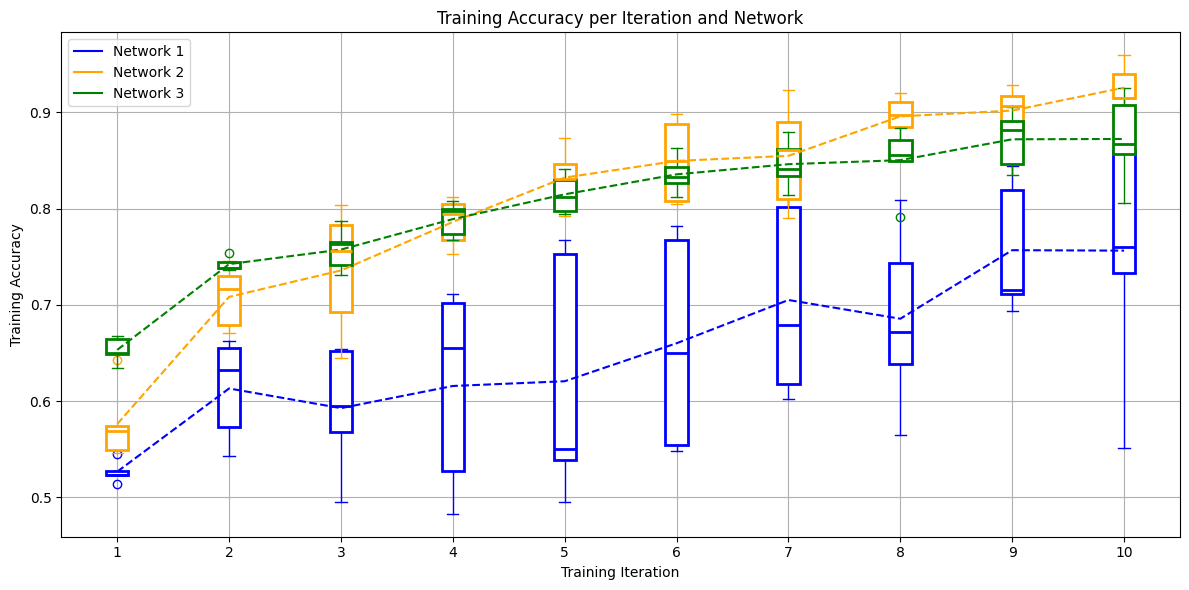

In [ ]:
num_increments = len(total_net1_train)
num_iters = len(total_net1_train[0])

plt.figure(figsize=(12, 6))

positions = np.arange(1, num_iters + 1)

# Prepare data for box plots
data_net1 = [[total_net1_train[inc][i] for inc in range(num_increments)] for i in range(num_iters)]
data_net2 = [[total_net2_train[inc][i] for inc in range(num_increments)] for i in range(num_iters)]
data_net3 = [[total_net3_train[inc][i] for inc in range(num_increments)] for i in range(num_iters)]

# Plot each network at the same iteration positions
def draw_box(data, color, label=None):
    box = plt.boxplot(data, positions=positions, patch_artist=True, widths=0.2, boxprops=dict(linewidth=2),
                      medianprops=dict(color=color, linewidth=2), whiskerprops=dict(color=color),
                      capprops=dict(color=color), flierprops=dict(markeredgecolor=color))
    for patch in box['boxes']:
        patch.set(facecolor='white', edgecolor=color, linewidth=2)
    if label:
        plt.plot([], [], color=color, label=label)  # Dummy handle for legend

# Draw all networks
draw_box(data_net1, 'blue', label='Network 1')
draw_box(data_net2, 'orange', label='Network 2')
draw_box(data_net3, 'green', label='Network 3')

# Optional: average lines
avg_net1 = [np.mean(d) for d in data_net1]
avg_net2 = [np.mean(d) for d in data_net2]
avg_net3 = [np.mean(d) for d in data_net3]

plt.plot(positions, avg_net1, color='blue', linestyle='--', linewidth=1.5)
plt.plot(positions, avg_net2, color='orange', linestyle='--', linewidth=1.5)
plt.plot(positions, avg_net3, color='green', linestyle='--', linewidth=1.5)

# Labels & grid
plt.xlabel('Training Iteration')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy per Iteration and Network')
plt.xticks(positions)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
total_net1_test = [i[0] for i in total_net1_test]
total_net2_test = [i[0] for i in total_net2_test]
total_net3_test = [i[0] for i in total_net3_test]

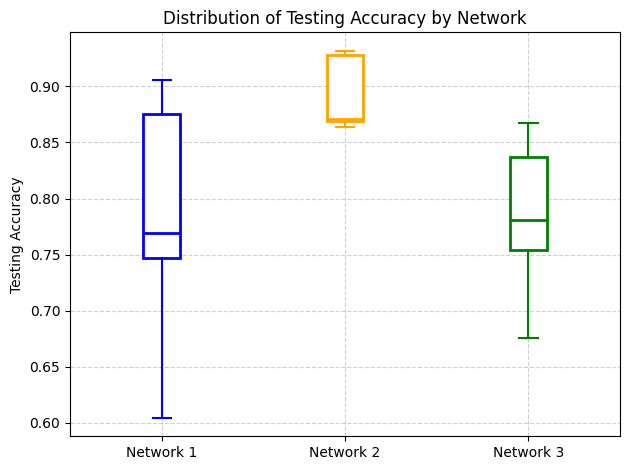

In [ ]:
# Prepare data
data = [total_net1_test, total_net2_test, total_net3_test]
colors = ['blue', 'orange', 'green']
labels = ['Network 1', 'Network 2', 'Network 3']

box = plt.boxplot(
    data,
    patch_artist=True,
    labels=labels,
    widths=0.2
)

# Set box properties
for patch, color in zip(box['boxes'], colors):
    patch.set(facecolor='white', edgecolor=color, linewidth=2)

for median, color in zip(box['medians'], colors):
    median.set_color(color)
    median.set_linewidth(2)

for whisker, color in zip(box['whiskers'], [c for color in colors for c in [color, color]]):
    whisker.set_color(color)
    whisker.set_linewidth(1.5)

for cap, color in zip(box['caps'], [c for color in colors for c in [color, color]]):
    cap.set_color(color)
    cap.set_linewidth(1.5)

for flier, color in zip(box['fliers'], colors):
    flier.set(markeredgecolor=color)

# Final touches
plt.title('Distribution of Testing Accuracy by Network')
plt.ylabel('Testing Accuracy')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Image Modification Demonstrated on a Randomly Selected Face

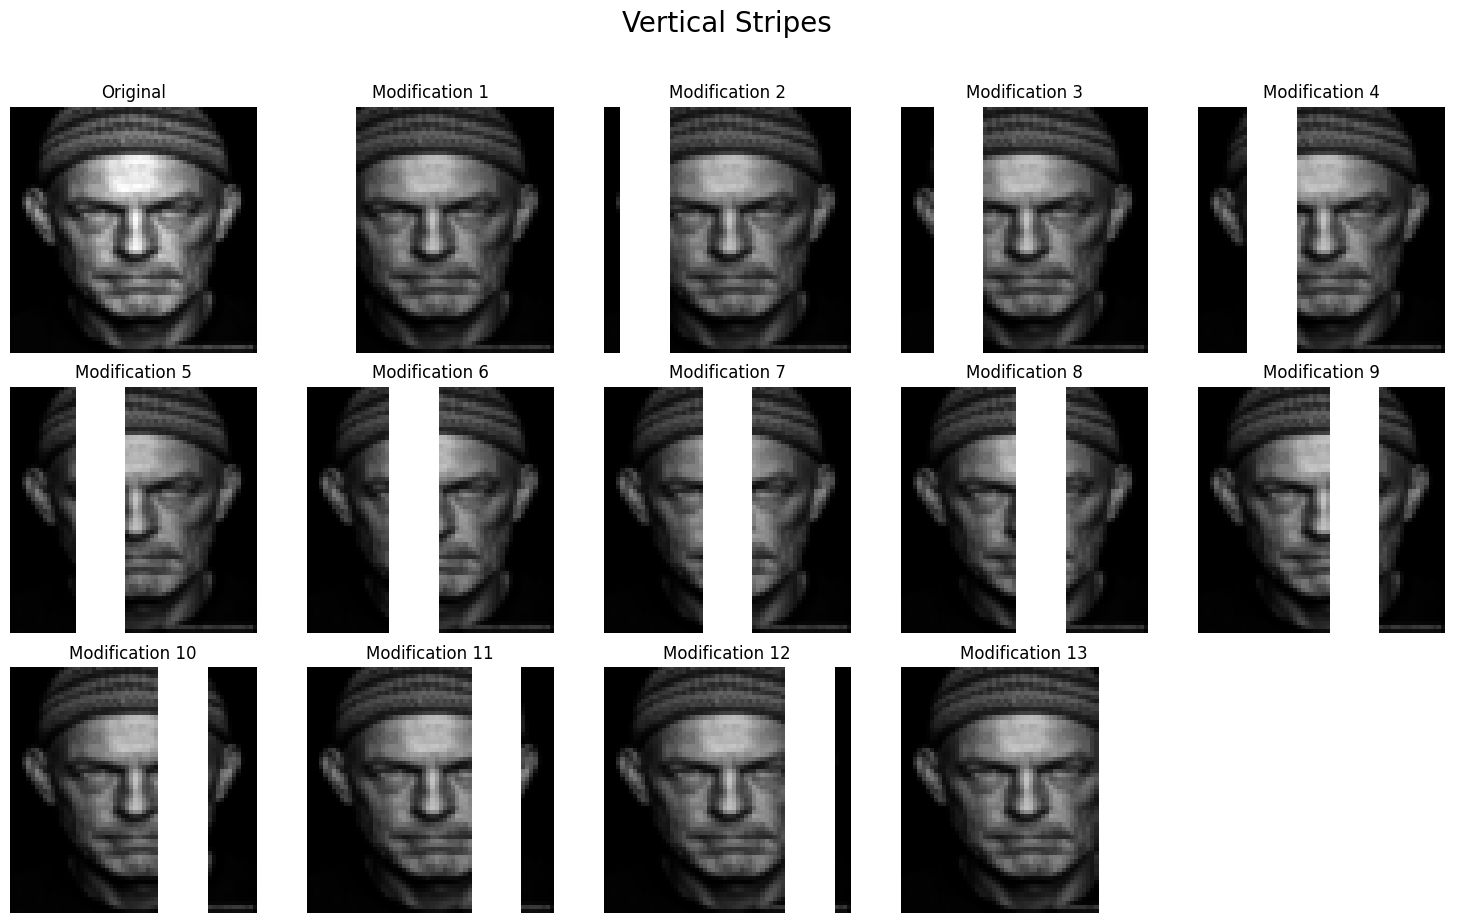

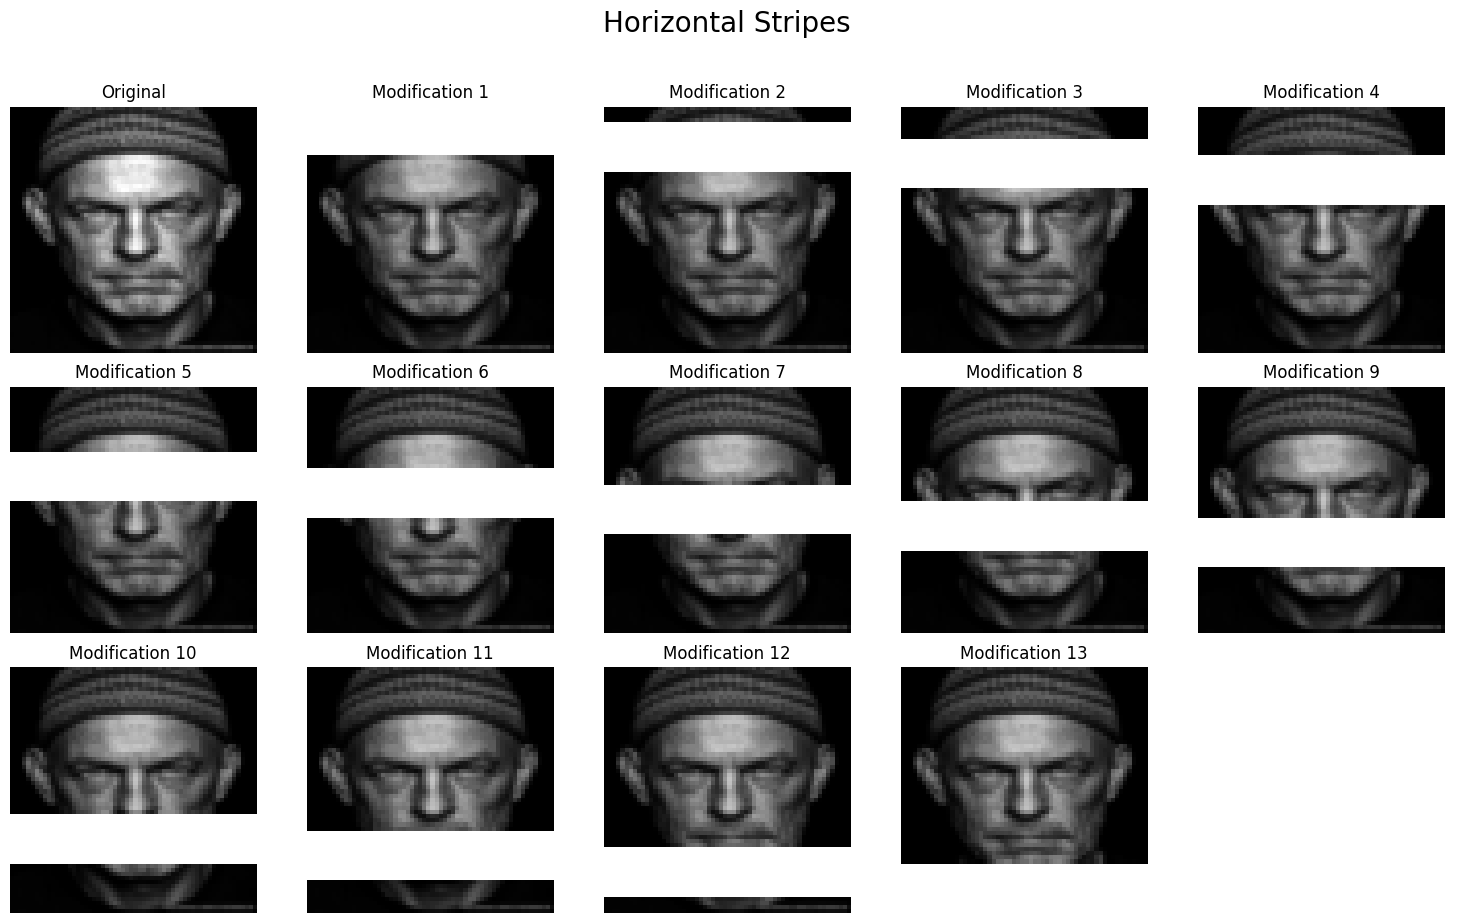

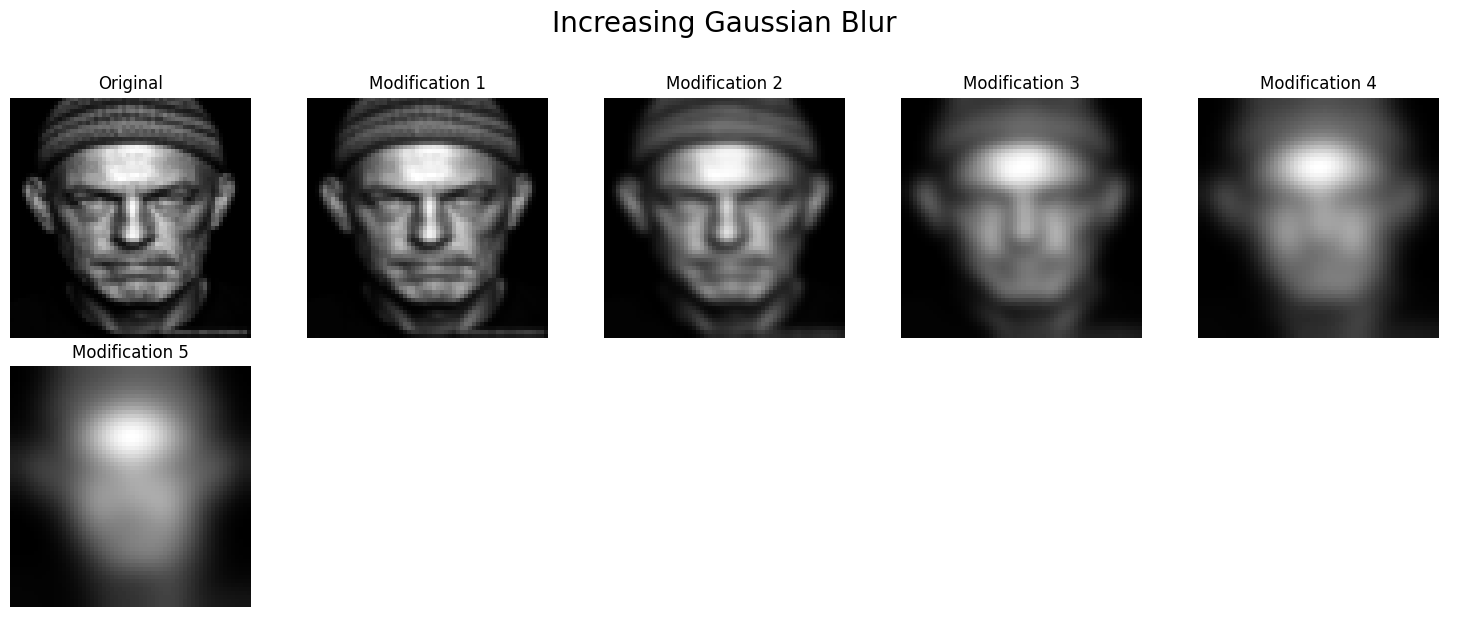

In [ ]:
# Pick a random face image where target != 0
target = 0
while target == 0:
    data, target = X_test[random.randint(0, len(X_test) - 1)]

data = data.unsqueeze(0)
target = torch.tensor([target])

stripe_size = 12
sigma_values = [0.5, 1,2,3,4]


def generate_full_shifted_stripes(data, stripe_size, direction):
    img_dim = data.shape[3] if direction == 'vertical' else data.shape[2]
    step = max(1, stripe_size // 3)
    num_shifts = (img_dim - stripe_size) // step + 1
    stripes = generate_shifted_stripes(data, stripe_size=stripe_size, direction=direction, step=step)
    return stripes[:num_shifts]

vertical_stripes = generate_full_shifted_stripes(data, stripe_size, 'vertical')
horizontal_stripes = generate_full_shifted_stripes(data, stripe_size, 'horizontal')
blur_images = [modify_image(data, 'blur', blur_size=bsize) for bsize in sigma_values]

def plot_modifications_group(images, title, max_per_row=5):
    total_mods = len(images)
    # +1 for original image included
    total_images = total_mods + 1
    num_rows = math.ceil(total_images / max_per_row)
    num_cols = max_per_row

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(3*num_cols, 3*num_rows))

    # Flatten axes for easier indexing
    axes = axes.flatten() if num_rows > 1 else [axes]

    for i in range(num_rows * num_cols):
        ax = axes[i]
        ax.axis('off')

        if i == 0:
            # Original image top-left corner
            ax.imshow(data[0, 0].detach().cpu().numpy(), cmap='gray')
            ax.set_title("Original")
        else:
            mod_idx = i - 1
            if mod_idx < total_mods:
                img = images[mod_idx]
                ax.imshow(img[0, 0].detach().cpu().numpy(), cmap='gray')
                ax.set_title(f"Modification {mod_idx + 1}")

    plt.suptitle(title, fontsize=20, y=1.02)
    plt.tight_layout()
    plt.show()

plot_modifications_group(vertical_stripes, "Vertical Stripes", max_per_row=5)
plot_modifications_group(horizontal_stripes, "Horizontal Stripes", max_per_row=5)
plot_modifications_group(blur_images, "Increasing Gaussian Blur", max_per_row=5)


### Testing and Result (Including Activation Layer Mapping) for the  Modified Image Above on all the CNNs

In [ ]:
networks = [network1, network2, network3]
titles = ["Network 1", "Network 2", "Network 3"]
network1_conv_layers = [network1.conv1, network1.conv2]
network2_conv_layers = [network2.conv1, network2.conv2, network2.conv3]
network3_conv_layers = [network3.layer1.conv1, network3.layer1.conv2, network3.layer2.conv1, network3.layer2.conv2, network3.layer3.conv1, network3.layer3.conv2]
network_conv_layers = [network1_conv_layers, network2_conv_layers, network3_conv_layers]


In [ ]:
probabilities_human = {
    "horizontal": {},
    "vertical": {},
    "blur": {},
    "original": {}
}

activations = {
    "horizontal": {},
    "vertical": {},
    "blur": {},
    "original": {}
}

correct_counts = {
    "horizontal": {},
    "vertical": {},
    "blur": {},
    "original": {}
}

# Loop over networks
for i, net in enumerate(networks):
    collector = ActivationCollector(network_conv_layers[i])
    net.eval()

    # Original image
    collector.clear_activations()
    with torch.no_grad():
      output_unmodified = net(data)
      pred_unmodified = output_unmodified.data.max(1, keepdim=True)[1]
      correct_unmodified = pred_unmodified.eq(target.data.view_as(pred_unmodified)).sum().item()
      probs_unmodified = F.softmax(output_unmodified, dim=1)
      human_prob_unmodified = probs_unmodified[0][1].item()

    activations["original"][i] = [a.clone().detach() for a in collector.get_activations()]
    probabilities_human["original"][i] = [human_prob_unmodified]
    correct_counts["original"][i] = correct_unmodified

    # Horizontal stripes
    probabilities_human["horizontal"][i] = []
    activations["horizontal"][i] = []
    correct_counts["horizontal"][i] = 0

    for img in horizontal_stripes:
        collector.clear_activations()
        with torch.no_grad():
          output = net(img)
          pred = output.data.max(1, keepdim=True)[1]
          correct = pred.eq(target.data.view_as(pred)).sum().item()
          probs = F.softmax(output, dim=1)
          human_prob = probs[0][1].item()

        probabilities_human["horizontal"][i].append(human_prob)
        activations["horizontal"][i].append([a.clone().detach() for a in collector.get_activations()])
        correct_counts["horizontal"][i] += correct

    # Vertical stripes
    probabilities_human["vertical"][i] = []
    activations["vertical"][i] = []
    correct_counts["vertical"][i] = 0
    for img in vertical_stripes:
        collector.clear_activations()
        with torch.no_grad():
          output = net(img)
          pred = output.data.max(1, keepdim=True)[1]
          correct = pred.eq(target.data.view_as(pred)).sum().item()
          probs = F.softmax(output, dim=1)
          human_prob = probs[0][1].item()

        probabilities_human["vertical"][i].append(human_prob)
        activations["vertical"][i].append([a.clone().detach() for a in collector.get_activations()])
        correct_counts["vertical"][i] += correct

    # Blurred images
    probabilities_human["blur"][i] = []
    activations["blur"][i] = []
    correct_counts["blur"][i] = 0
    for img in blur_images:
        collector.clear_activations()
        with torch.no_grad():
          output = net(img)
          pred = output.data.max(1, keepdim=True)[1]
          correct = pred.eq(target.data.view_as(pred)).sum().item()
          probs = F.softmax(output, dim=1)
          human_prob = probs[0][1].item()

        probabilities_human["blur"][i].append(human_prob)
        activations["blur"][i].append([a.clone().detach() for a in collector.get_activations()])
        correct_counts["blur"][i] += correct

    collector.remove_hooks()

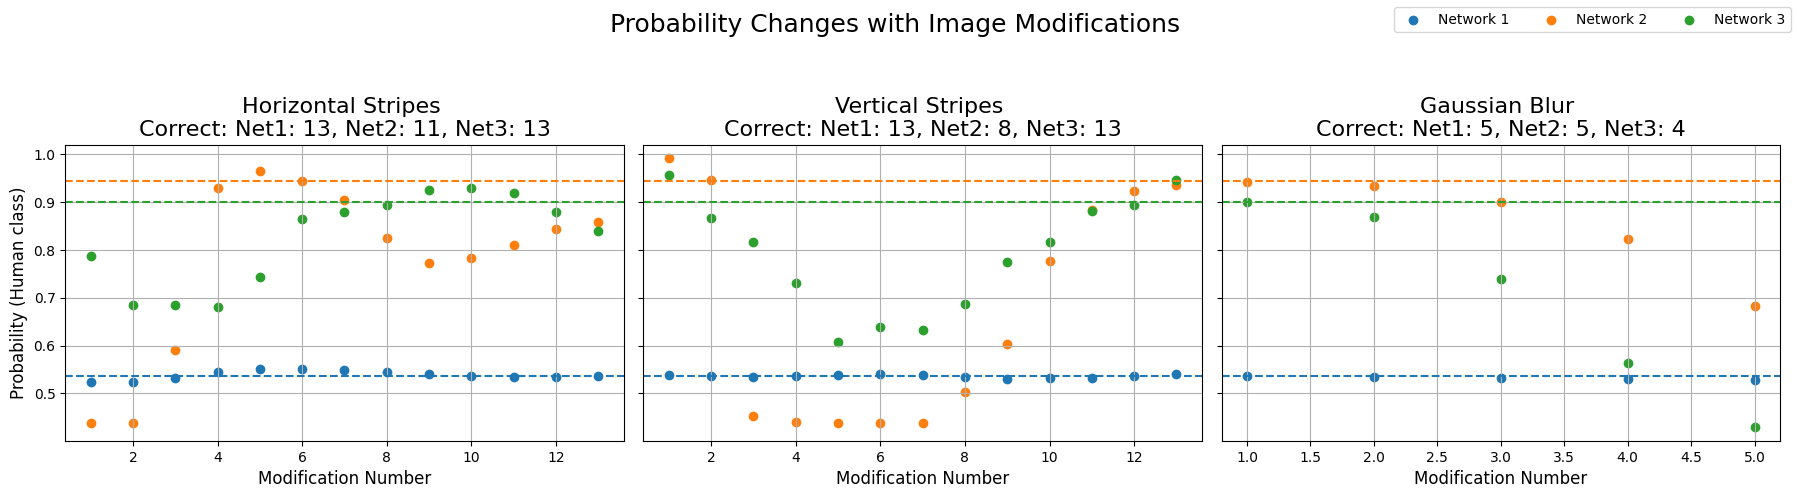

In [ ]:
# Define labels and colors
mods = ["horizontal", "vertical", "blur"]
colors = ['tab:blue', 'tab:orange', 'tab:green']
titles = ["Horizontal Stripes", "Vertical Stripes", "Gaussian Blur"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

scatter_handles = []

for j, mod in enumerate(mods):
    ax = axes[j]

    for i in range(len(networks)):
        probs = probabilities_human[mod][i]  # List of probabilities
        baseline = probabilities_human["original"][i][0]  # Single float

        # Plot scatter of probabilities
        scatter = ax.scatter(range(1, len(probs)+1), probs, label=f"Network {i+1}", color=colors[i])

        # Save the handle for the legend
        if j == 0:
            scatter_handles.append(scatter)

        # Plot baseline
        ax.axhline(baseline, color=colors[i], linestyle='--', linewidth=1.5)

    # Create correct counts string per network
    correct_strs = [f"Net{i+1}: {correct_counts[mod].get(i, 0)}" for i in range(len(networks))]
    correct_title = ", ".join(correct_strs)

    ax.set_title(f"{titles[j]} \nCorrect: {correct_title}", fontsize=16)
    ax.set_xlabel("Modification Number", fontsize=12)
    ax.grid(True)

axes[0].set_ylabel("Probability (Human class)", fontsize=12)
fig.suptitle("Probability Changes with Image Modifications", fontsize=18)
fig.legend(handles=scatter_handles,ncol=len(networks))
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


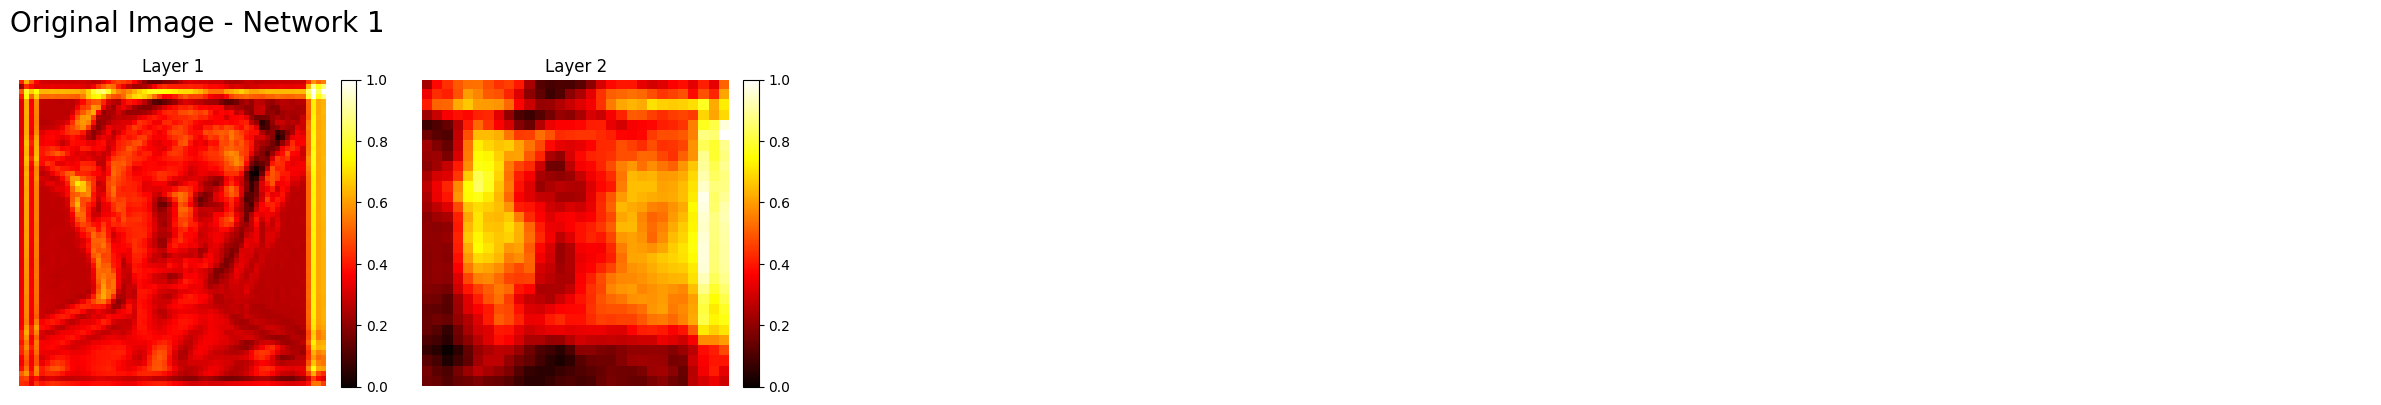

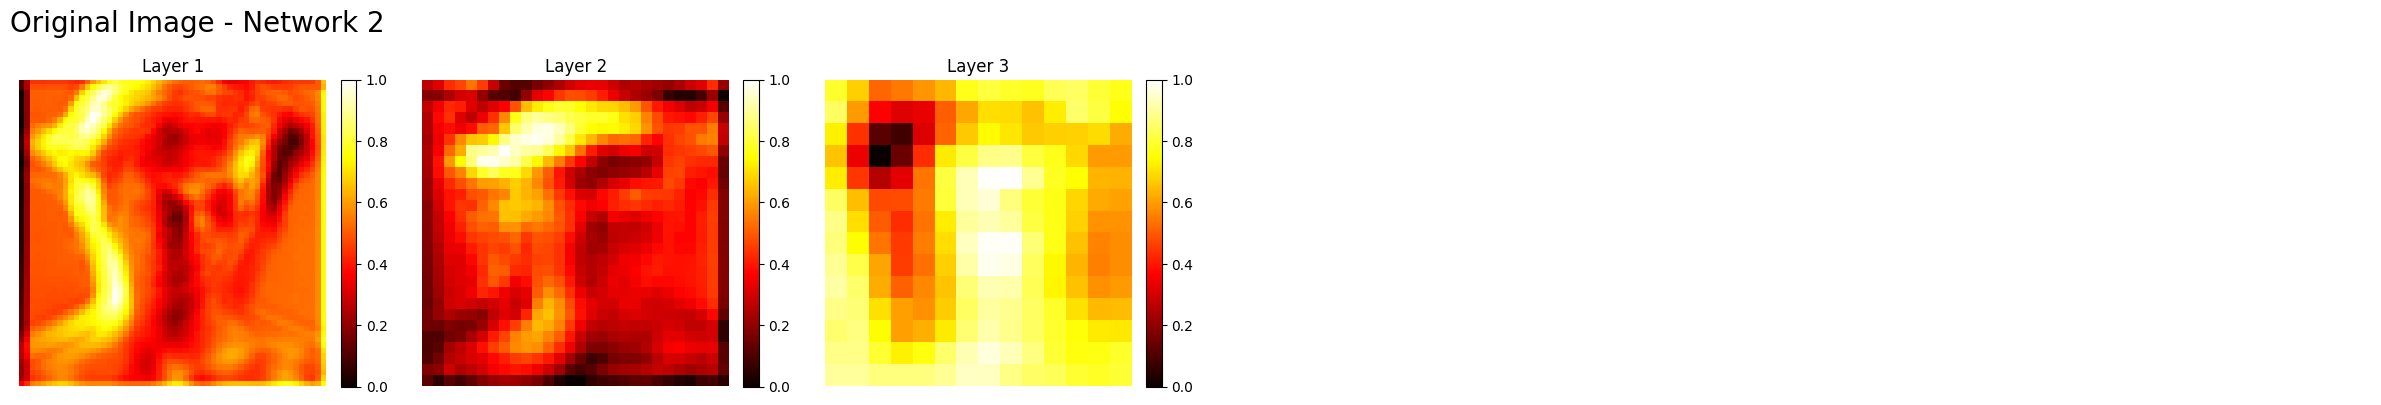

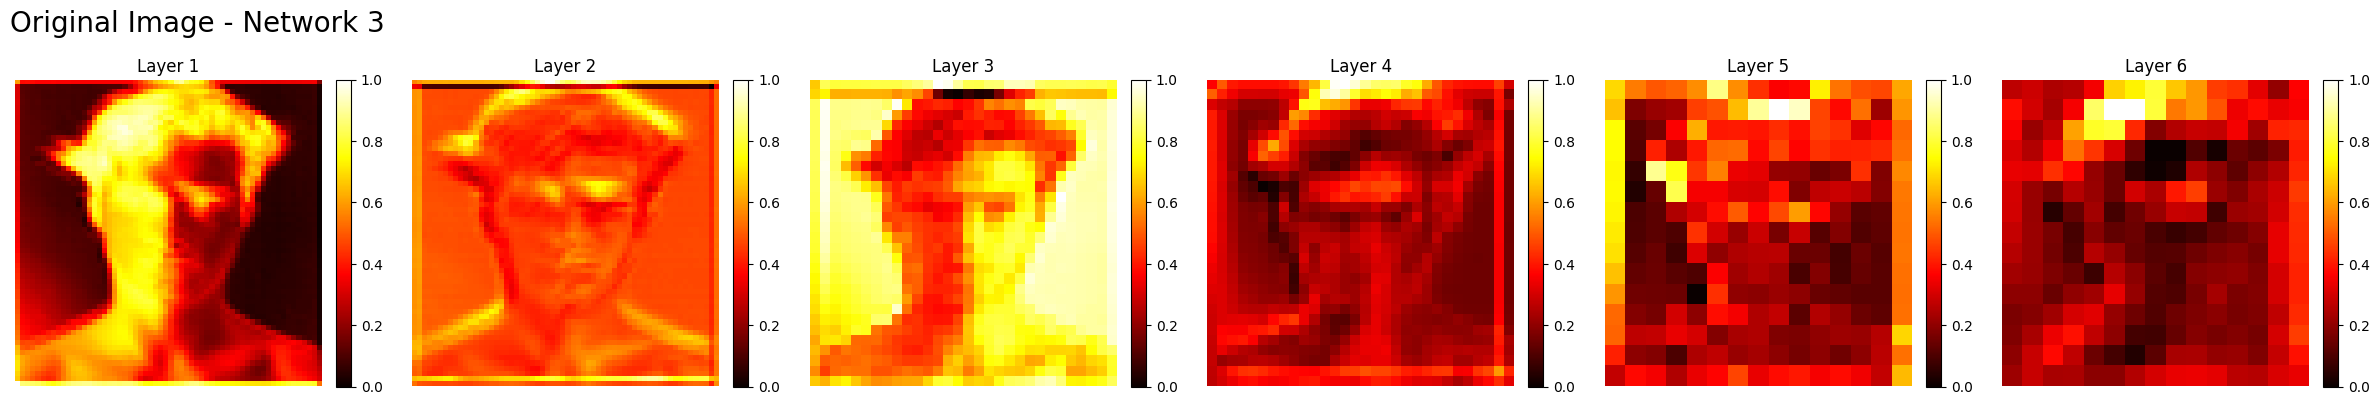

In [ ]:
def plot_original_activations_grid(activations, titles, max_per_row=6):
    '''
    Plots last filter activation maps for original images for each network in a grid format.

    Parameters:
    - activations: dictionary with key 'original' → activations['original'][i] is a list of activation tensors for network i
    - titles: list of strings like ["Network 1", "Network 2", ...]
    - max_per_row: maximum number of subplots per row
    '''
    for i, net_title in enumerate(titles):
        acts = activations['original'][i]  # List of activations for this network

        num_layers = len(acts)
        num_rows = (num_layers + max_per_row - 1) // max_per_row

        fig, axes = plt.subplots(num_rows, max_per_row, figsize=(4 * max_per_row, 4 * num_rows))
        axes = np.array(axes).reshape(num_rows, max_per_row)

        for idx in range(num_rows * max_per_row):
            row, col = divmod(idx, max_per_row)
            ax = axes[row, col]

            if idx < num_layers:
                last_map = acts[idx][0, -1].detach().numpy()
                normalized_map = (last_map - np.min(last_map)) / (np.max(last_map) - np.min(last_map) + 1e-8)
                im = ax.imshow(normalized_map, cmap='hot')
                ax.set_title(f"Layer {idx+1}")
                ax.axis('off')
                fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            else:
                ax.axis('off')

        fig.suptitle(f"Original Image - {net_title}", fontsize=20, ha='left', x=0.01)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

plot_original_activations_grid(activations, ["Network 1", "Network 2", "Network 3"])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_all_activations(activations, titles, mods=["original", "horizontal", "vertical", "blur"], max_per_row=6):
    for mod in mods:
        for net_idx, net_title in enumerate(titles):
            if mod == "original":
                # Just one image activations per network
                acts = activations[mod][net_idx]
                num_layers = len(acts)
                num_rows = (num_layers + max_per_row - 1) // max_per_row

                fig, axes = plt.subplots(num_rows, max_per_row, figsize=(4 * max_per_row, 4 * num_rows))
                axes = np.array(axes).reshape(num_rows, max_per_row)

                for idx in range(num_rows * max_per_row):
                    row, col = divmod(idx, max_per_row)
                    ax = axes[row, col]
                    if idx < num_layers:
                        last_map = acts[idx][0, -1].detach().cpu().numpy()
                        normalized_map = (last_map - np.min(last_map)) / (np.max(last_map) - np.min(last_map) + 1e-8)
                        im = ax.imshow(normalized_map, cmap='hot')
                        ax.set_title(f"Layer {idx + 1}")
                        ax.axis('off')
                        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
                    else:
                        ax.axis('off')

                fig.suptitle(f"{mod.capitalize()} - {net_title}", fontsize=18, ha='left', x=0.01)
                plt.tight_layout(rect=[0, 0, 1, 0.95])
                plt.show()

            else:
                # Multiple modified images, each with activations for all layers
                acts_list = activations[mod][net_idx]  # list of images, each is list of activations per layer

                for img_idx, acts in enumerate(acts_list):
                    num_layers = len(acts)
                    num_rows = (num_layers + max_per_row - 1) // max_per_row

                    fig, axes = plt.subplots(num_rows, max_per_row, figsize=(4 * max_per_row, 4 * num_rows))
                    axes = np.array(axes).reshape(num_rows, max_per_row)

                    for idx in range(num_rows * max_per_row):
                        row, col = divmod(idx, max_per_row)
                        ax = axes[row, col]
                        if idx < num_layers:
                            last_map = acts[idx][0, -1].detach().cpu().numpy()
                            normalized_map = (last_map - np.min(last_map)) / (np.max(last_map) - np.min(last_map) + 1e-8)
                            im = ax.imshow(normalized_map, cmap='hot')
                            ax.set_title(f"Layer {idx + 1}")
                            ax.axis('off')
                            fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
                        else:
                            ax.axis('off')

                    fig.suptitle(f"{mod.capitalize()} - Image {img_idx + 1} - {net_title}", fontsize=18, ha='left', x=0.01)
                    plt.tight_layout(rect=[0, 0, 1, 0.95])
                    plt.show()

plot_all_activations(activations, ["Network 1", "Network 2", "Network 3"])

### Create Testing Data Loaders for all Possibe Image Modifications

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

def create_modified_tensor_lists(X_test, stripe_size, sigma_values):
    # Initialize storage
    human_vertical_stripes = []
    human_horizontal_stripes = []
    human_blur_variants = [[] for _ in sigma_values]

    other_vertical_stripes = []
    other_horizontal_stripes = []
    other_blur_variants = [[] for _ in sigma_values]

    for data, label in X_test:
        if data.dim() == 3:
            data = data.unsqueeze(0)  # Ensure shape is [1, C, H, W]

        # Generate modifications
        vertical_stripes = generate_shifted_stripes(data, stripe_size, stripe_size // 3, 'vertical')
        horizontal_stripes = generate_shifted_stripes(data, stripe_size, stripe_size // 3, 'horizontal')
        blur_images = [modify_image(data, 'blur', blur_size=s) for s in sigma_values]

        target = torch.tensor(label)  # Convert label to tensor for pairing

        # Store data in appropriate category
        if label == 1:  # Human
            for i, img in enumerate(vertical_stripes):
                if len(human_vertical_stripes) <= i:
                    human_vertical_stripes.append([])
                human_vertical_stripes[i].append((img.squeeze(0), target))

            for i, img in enumerate(horizontal_stripes):
                if len(human_horizontal_stripes) <= i:
                    human_horizontal_stripes.append([])
                human_horizontal_stripes[i].append((img.squeeze(0), target))

            for i, img in enumerate(blur_images):
                human_blur_variants[i].append((img.squeeze(0), target))

        else:  # Other
            for i, img in enumerate(vertical_stripes):
                if len(other_vertical_stripes) <= i:
                    other_vertical_stripes.append([])
                other_vertical_stripes[i].append((img.squeeze(0), target))

            for i, img in enumerate(horizontal_stripes):
                if len(other_horizontal_stripes) <= i:
                    other_horizontal_stripes.append([])
                other_horizontal_stripes[i].append((img.squeeze(0), target))

            for i, img in enumerate(blur_images):
                other_blur_variants[i].append((img.squeeze(0), target))

    # Helper function to convert list of (image, label) tuples to TensorDataset
    def make_tensors(list_of_tuples):
        images = torch.stack([x[0] for x in list_of_tuples])
        labels = torch.stack([x[1] for x in list_of_tuples])
        return TensorDataset(images, labels)

    X_test_human_vertical = [make_tensors(batch) for batch in human_vertical_stripes]
    X_test_human_horizontal = [make_tensors(batch) for batch in human_horizontal_stripes]
    X_test_human_blur = [make_tensors(batch) for batch in human_blur_variants]

    X_test_other_vertical = [make_tensors(batch) for batch in other_vertical_stripes]
    X_test_other_horizontal = [make_tensors(batch) for batch in other_horizontal_stripes]
    X_test_other_blur = [make_tensors(batch) for batch in other_blur_variants]

    return (
        X_test_human_vertical, X_test_human_horizontal, X_test_human_blur,
        X_test_other_vertical, X_test_other_horizontal, X_test_other_blur
    )


# Call the function
(
    X_test_human_vertical, X_test_human_horizontal, X_test_human_blur,
    X_test_other_vertical, X_test_other_horizontal, X_test_other_blur
) = create_modified_tensor_lists(X_test, stripe_size, sigma_values)


# Create DataLoaders directly from TensorDatasets
human_vertical_loaders = [
    DataLoader(dataset, batch_size=100, shuffle=True) for dataset in X_test_human_vertical
]
human_horizontal_loaders = [
    DataLoader(dataset, batch_size=100, shuffle=True) for dataset in X_test_human_horizontal
]
human_blur_loaders = [
    DataLoader(dataset, batch_size=100, shuffle=True) for dataset in X_test_human_blur
]

other_vertical_loaders = [
    DataLoader(dataset, batch_size=100, shuffle=True) for dataset in X_test_other_vertical
]
other_horizontal_loaders = [
    DataLoader(dataset, batch_size=100, shuffle=True) for dataset in X_test_other_horizontal
]
other_blur_loaders = [
    DataLoader(dataset, batch_size=100, shuffle=True) for dataset in X_test_other_blur
]

# Print summary
print(
    "Human Vertical Loaders:", len(human_vertical_loaders),
    "\nHuman Horizontal Loaders:", len(human_horizontal_loaders),
    "\nHuman Blur Loaders:", len(human_blur_loaders),
    "\nOther Vertical Loaders:", len(other_vertical_loaders),
    "\nOther Horizontal Loaders:", len(other_horizontal_loaders),
    "\nOther Blur Loaders:", len(other_blur_loaders)
)


Human Vertical Loaders: 13 
Human Horizontal Loaders: 13 
Human Blur Loaders: 5 
Other Vertical Loaders: 13 
Other Horizontal Loaders: 13 
Other Blur Loaders: 5


### Testing and Result Collection for Modified Images on all the CNNs

In [ ]:
scores_vertical_net1, scores_horizontal_net1, scores_blur_net1 = [], [], []
for i in range(len(human_vertical_loaders)):
    score_vertical = test_net(network1, human_vertical_loaders[i])
    score_horizontal = test_net(network1, human_horizontal_loaders[i])
    scores_vertical_net1.append(score_vertical)
    scores_horizontal_net1.append(score_horizontal)

for i in range(len(human_blur_loaders)):
    score_blur = test_net(network1, human_blur_loaders[i])
    scores_blur_net1.append(score_blur)


scores_vertical_net2, scores_horizontal_net2, scores_blur_net2 = [], [], []
for i in range(len(human_vertical_loaders)):
    score_vertical = test_net(network2, human_vertical_loaders[i])
    score_horizontal = test_net(network2, human_horizontal_loaders[i])
    scores_vertical_net2.append(score_vertical)
    scores_horizontal_net2.append(score_horizontal)

for i in range(len(human_blur_loaders)):
    score_blur = test_net(network2, human_blur_loaders[i])
    scores_blur_net2.append(score_blur)


scores_vertical_net3, scores_horizontal_net3, scores_blur_net3 = [], [], []
for i in range(len(human_vertical_loaders)):
    score_vertical = test_net(network3, human_vertical_loaders[i])
    score_horizontal = test_net(network3, human_horizontal_loaders[i])
    scores_vertical_net3.append(score_vertical)
    scores_horizontal_net3.append(score_horizontal)

for i in range(len(human_blur_loaders)):
    score_blur = test_net(network3, human_blur_loaders[i])
    scores_blur_net3.append(score_blur)


In [ ]:
total_net1_test_vertical, total_net2_test_vertical, total_net3_test_vertical = [], [], []
total_net1_test_horizontal, total_net2_test_horizontal, total_net3_test_horizontal = [], [], []
total_net1_test_blur, total_net2_test_blur, total_net3_test_blur = [], [], []


for fold in range(5):
    print(f'-----Fold {fold+1}-----')
    X_train, X_test, train_loader, test_loader = prepare_train_and_test(
        dataset, PERCENT_TOTAL, PERCENT_TRAIN, test_fifth=fold
    )

    (
        X_test_human_vertical, X_test_human_horizontal, X_test_human_blur,
        X_test_other_vertical, X_test_other_horizontal, X_test_other_blur
    ) = create_modified_tensor_lists(X_test, stripe_size, sigma_values)

    human_vertical_loaders = [DataLoader(ds, batch_size=100, shuffle=True) for ds in X_test_human_vertical]
    human_horizontal_loaders = [DataLoader(ds, batch_size=100, shuffle=True) for ds in X_test_human_horizontal]
    human_blur_loaders = [DataLoader(ds, batch_size=100, shuffle=True) for ds in X_test_human_blur]

    network1 = network1_all[fold]
    network2 = network2_all[fold]
    network3 = network3_all[fold]

    scores_vertical_net1, scores_horizontal_net1, scores_blur_net1 = [], [], []
    scores_vertical_net2, scores_horizontal_net2, scores_blur_net2 = [], [], []
    scores_vertical_net3, scores_horizontal_net3, scores_blur_net3 = [], [], []

    for i in range(len(human_vertical_loaders)):
        scores_vertical_net1.append(test_net(network1, human_vertical_loaders[i]))
        scores_horizontal_net1.append(test_net(network1, human_horizontal_loaders[i]))

        scores_vertical_net2.append(test_net(network2, human_vertical_loaders[i]))
        scores_horizontal_net2.append(test_net(network2, human_horizontal_loaders[i]))

        scores_vertical_net3.append(test_net(network3, human_vertical_loaders[i]))
        scores_horizontal_net3.append(test_net(network3, human_horizontal_loaders[i]))

    for i in range(len(human_blur_loaders)):
        scores_blur_net1.append(test_net(network1, human_blur_loaders[i]))
        scores_blur_net2.append(test_net(network2, human_blur_loaders[i]))
        scores_blur_net3.append(test_net(network3, human_blur_loaders[i]))

    # Store average score for the fold
    total_net1_test_vertical.append(scores_vertical_net1)
    total_net1_test_horizontal.append(scores_horizontal_net1)
    total_net1_test_blur.append(scores_blur_net1)

    total_net2_test_vertical.append((scores_vertical_net2))
    total_net2_test_horizontal.append((scores_horizontal_net2))
    total_net2_test_blur.append((scores_blur_net2))

    total_net3_test_vertical.append((scores_vertical_net3))
    total_net3_test_horizontal.append((scores_horizontal_net3))
    total_net3_test_blur.append((scores_blur_net3))


-----Fold 1-----
-----Fold 2-----
-----Fold 3-----
-----Fold 4-----
-----Fold 5-----


In [ ]:
total_net1_test_vertical = [float(i) for i in total_net1_test_vertical]
total_net1_test_horizontal = [float(i) for i in total_net1_test_horizontal]
total_net1_test_blur= [float(i) for i in total_net1_test_blur]

total_net2_test_vertical = [float(i) for i in total_net2_test_vertical]
total_net2_test_horizontal = [float(i) for i in total_net2_test_horizontal]
total_net2_test_blur= [float(i) for i in total_net2_test_blur]

total_net3_test_vertical = [float(i) for i in total_net3_test_vertical]
total_net3_test_horizontal = [float(i) for i in total_net3_test_horizontal]
total_net3_test_blur= [float(i) for i in total_net3_test_blur]


In [ ]:
total_net1_test_vertical = big_list(scores_vertical_net1)
total_net2_test_vertical = big_list(scores_vertical_net2)
total_net3_test_vertical = big_list(scores_vertical_net3)

total_net1_test_horizontal = big_list(scores_horizontal_net1)
total_net2_test_horizontal = big_list(scores_horizontal_net2)
total_net3_test_horizontal = big_list(scores_horizontal_net3)

total_net1_test_blur = big_list(scores_blur_net1)
total_net2_test_blur = big_list(scores_blur_net2)
total_net3_test_blur = big_list(scores_blur_net3)

### Computing Result Statistics + Display

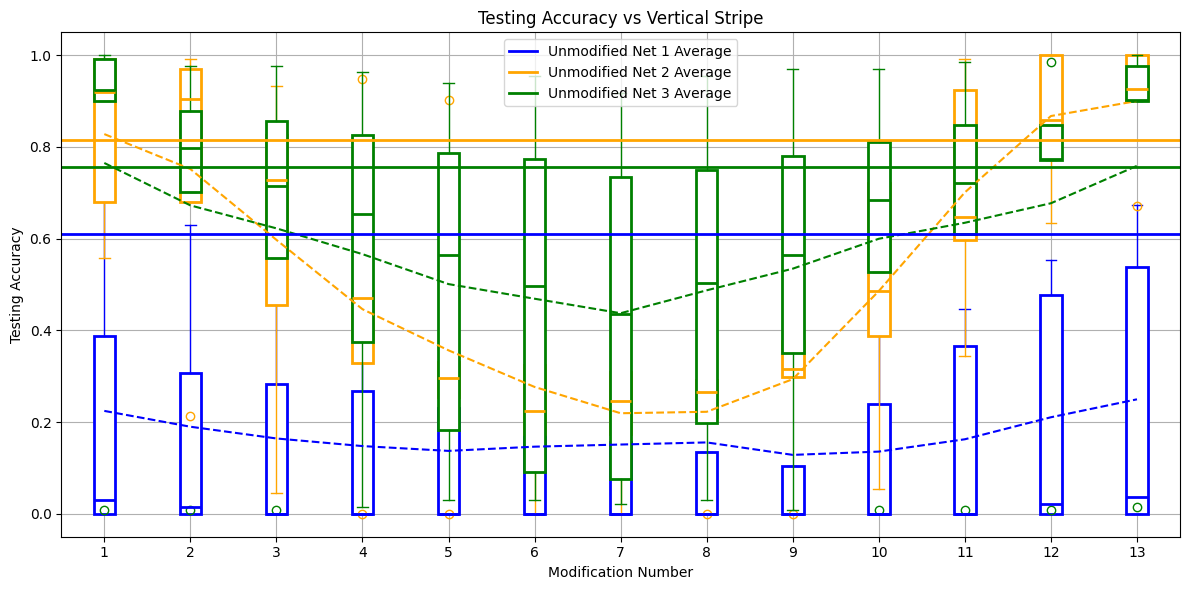

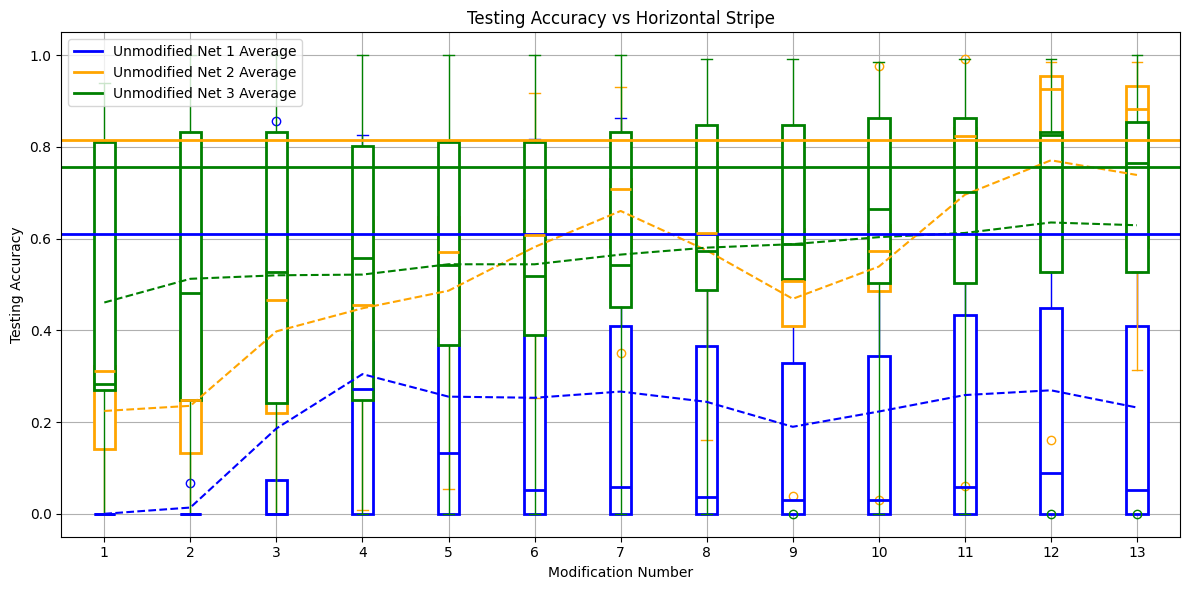

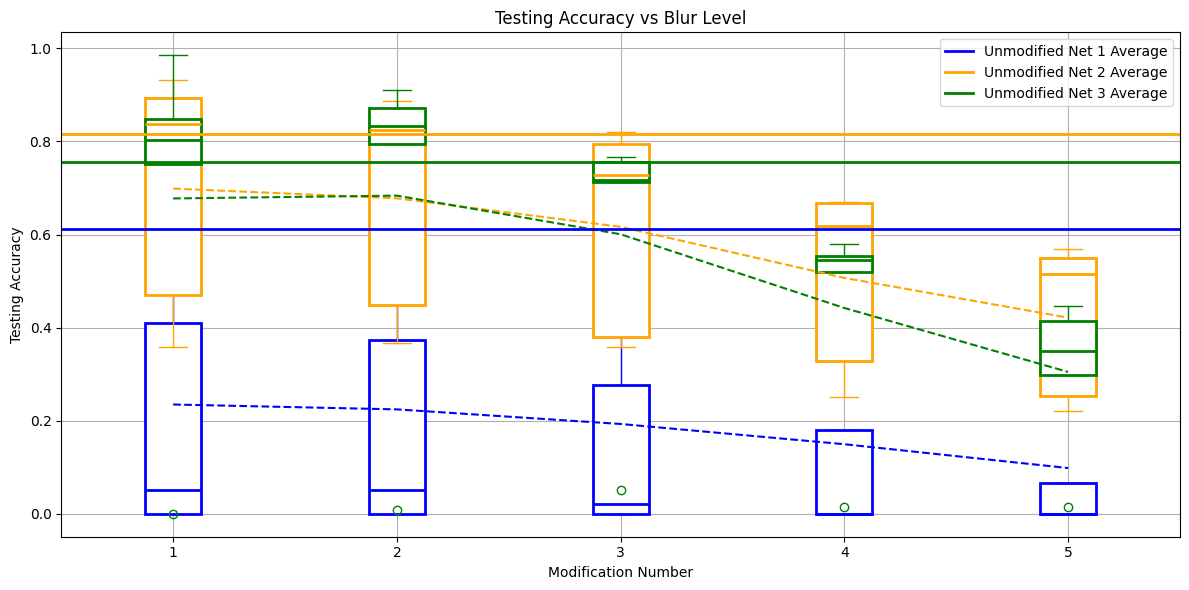

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def prepare_box_data(total_net):
    # total_net assumed to be a list of lists (increments × iterations)
    num_increments = len(total_net)
    num_iters = len(total_net[0])
    return [[total_net[inc][i] for inc in range(num_increments)] for i in range(num_iters)]

def compute_avg_line(total_net):
    num_increments = len(total_net)
    num_iters = len(total_net[0])
    return [np.mean([total_net[inc][i] for inc in range(num_increments)]) for i in range(num_iters)]

def draw_box(data, color, label=None):
    positions = np.arange(1, len(data)+1)
    box = plt.boxplot(data, positions=positions, patch_artist=True, widths=0.25,
                      boxprops=dict(linewidth=2),
                      medianprops=dict(color=color, linewidth=2),
                      whiskerprops=dict(color=color),
                      capprops=dict(color=color),
                      flierprops=dict(markeredgecolor=color))
    for patch in box['boxes']:
        patch.set(facecolor='white', edgecolor=color, linewidth=2)
    if label:
        plt.plot([], [], color=color, label=label)  # dummy for legend

def plot_accuracy(total_net1, total_net2, total_net3, baseline_net1, baseline_net2, baseline_net3,
                  title, ylabel):
    data_net1 = prepare_box_data(total_net1)
    data_net2 = prepare_box_data(total_net2)
    data_net3 = prepare_box_data(total_net3)

    plt.figure(figsize=(12, 6))

    draw_box(data_net1, 'blue')
    draw_box(data_net2, 'orange')
    draw_box(data_net3, 'green')

    avg_net1 = compute_avg_line(total_net1)
    avg_net2 = compute_avg_line(total_net2)
    avg_net3 = compute_avg_line(total_net3)

    positions = np.arange(1, len(avg_net1) + 1)

    # plt.plot(positions, avg_net1, color='blue', linestyle='--', linewidth=1.5)
    # plt.plot(positions, avg_net2, color='orange', linestyle='--', linewidth=1.5)
    # plt.plot(positions, avg_net3, color='green', linestyle='--', linewidth=1.5)

    # Baseline average is just the mean of the flat list
    baseline_avg_net1 = np.mean(baseline_net1)
    baseline_avg_net2 = np.mean(baseline_net2)
    baseline_avg_net3 = np.mean(baseline_net3)

    # Plot constant horizontal solid line for baseline average
    plt.axhline(y=baseline_avg_net1, color='blue', linestyle='-', linewidth=2, label='Unmodified Net 1 Average')
    plt.axhline(y=baseline_avg_net2, color='orange', linestyle='-', linewidth=2, label='Unmodified Net 2 Average')
    plt.axhline(y=baseline_avg_net3, color='green', linestyle='-', linewidth=2, label='Unmodified Net 3 Average')

    plt.xlabel('Modification Number')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(positions)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Usage example:

plot_accuracy(
    total_net1_test_vertical, total_net2_test_vertical, total_net3_test_vertical,
    total_net1_test, total_net2_test, total_net3_test,
    'Testing Accuracy vs Vertical Stripe', 'Testing Accuracy'
)

plot_accuracy(
    total_net1_test_horizontal, total_net2_test_horizontal, total_net3_test_horizontal,
    total_net1_test, total_net2_test, total_net3_test,
    'Testing Accuracy vs Horizontal Stripe', 'Testing Accuracy'
)

plot_accuracy(
    total_net1_test_blur, total_net2_test_blur, total_net3_test_blur,
    total_net1_test, total_net2_test, total_net3_test,
    'Testing Accuracy vs Blur Level', 'Testing Accuracy'
)
